# Finding the Best Neural Network Model

## Import Necessary libraries

In [1]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.4.0'
spark_version = 'spark-3.5.0'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,304 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,578 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/main am

In [2]:
# download necessary libraries
!pip install boto3
!pip install split-folders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 8.5 MB/s eta 0:00:00


In [12]:
# Importing Modules and libraries needed for AWS S3 storage, Deep Learning and Image Processing
import boto3
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.sql.types import StringType
from concurrent.futures import ProcessPoolExecutor, wait

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import matplotlib.pyplot as plt
from PIL import Image
import IPython.display as display

import tensorflow as tf
from tensorflow import keras

import splitfolders
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from keras import layers
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.applications import ResNet50, DenseNet121, MobileNet, EfficientNetV2B0

from keras.layers import Dense, GlobalAveragePooling2D
from config import aws_access_key_id, aws_secret_access_key

## Data Collection

In [14]:
# Initialize Spark session
spark = SparkSession.builder.appName("S3ImageDownloader").getOrCreate()

aws_access_key_id = aws_access_key_id
aws_secret_access_key = aws_secret_access_key
region_name = "us-east-2"
bucket_name = "capstone-pill-images"
data_prefix = "data/data"

In [15]:
# Create an S3 client
s3 = boto3.client(
    's3',
     aws_access_key_id=aws_access_key_id,
     aws_secret_access_key=aws_secret_access_key,
     region_name=region_name
)
def download_file_from_s3(key, bucket_name, local_directory):
    local_path = os.path.join(local_directory, os.path.relpath(key, prefix))
    os.makedirs(os.path.dirname(local_path), exist_ok=True)
    s3.download_file(bucket_name, key, local_path)
    return local_path

In [16]:
# List objects from S3
bucket_name = bucket_name
prefix = data_prefix
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=data_prefix)
keys = [obj['Key'] for obj in response.get('Contents', [])]

In [17]:
# Create a Spark DataFrame with a single column 'key' and explicit StringType schema
schema = StringType()
df = spark.createDataFrame(keys, schema).toDF('key')


In [18]:
# Use concurrent.futures.ProcessPoolExecutor for multiprocessing
with ProcessPoolExecutor() as executor:
    # Submit download tasks to the executor
    futures = [executor.submit(download_file_from_s3, key, bucket_name, 'local_drug_directory') for key in keys]

    # Wait for all tasks to complete
    wait(futures)

<ipython-input-19-82783988bbfd>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_images = [Image.open(image_future.result()).resize(common_size, Image.ANTIALIAS) for image_future in random_images]


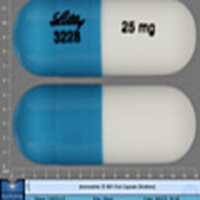

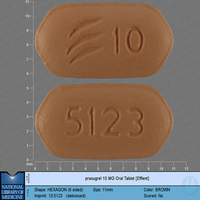

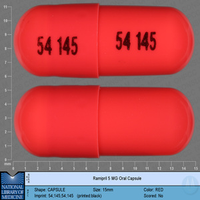

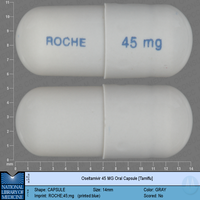

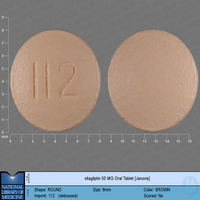

In [19]:
# Randomly select 5 images
random_images = random.sample(futures, 5)

# Resize images to a common size
common_size = (200, 200)  # Adjust as needed
resized_images = [Image.open(image_future.result()).resize(common_size, Image.ANTIALIAS) for image_future in random_images]

# Display the resized images horizontally
display.display(*resized_images)

## Data Preprocessing

In [20]:
# define path for local directory
local_drug_directory = "local_drug_directory"

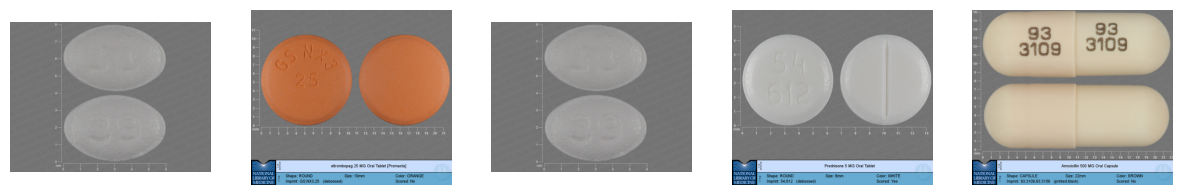

In [22]:
# get images to display from local directory
def show_sample_images(local_directory):
    # Go into the local directory and put all subdirectories in a List
    subdirectories = [d for d in os.listdir(local_directory) if os.path.isdir(os.path.join(local_directory, d))]

    # Check if there are any subdirectories
    if not subdirectories:
        print("No subdirectories found in the directory.")
        return

    # Collect all image files from all subdirectories
    all_image_files = []
    for subdirectory in subdirectories:
        subdirectory_path = os.path.join(local_directory, subdirectory)

        # List all image files in the subdirectory
        image_files = [f for f in os.listdir(subdirectory_path) if f.lower().endswith(('.jpg', '.jpeg'))]

        # Add the image files to the combined list
        all_image_files.extend(os.path.join(subdirectory_path, f) for f in image_files)

    # Shuffle the combined list of image files
    random.shuffle(all_image_files)

    # Set the number of random images to display
    num_images_to_display = 5

    # Create subplots to display images side by side
    fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 3))  # Adjust figsize as needed

    # Loop to select and display 5 random images
    for i in range(num_images_to_display):
        # Check if there are still image files available
        if not all_image_files:
            break

        # Pop a random image from the combined list
        random_image_file = all_image_files.pop()

        # Load and display the randomly selected image
        img = mpimg.imread(random_image_file)

        # Display the image in the subplot
        axes[i].imshow(img)
        axes[i].axis('off')  # Turn off axis labels

    # Show the subplots
    plt.show()

# Example usage
show_sample_images(local_drug_directory)

In [23]:
# Split the downloaded image folder into train, validation, and test folders
splitfolders.ratio(local_drug_directory, output="output", seed=1337, ratio=(.8, 0.1, 0.1))

Copying files: 552 files [00:00, 2818.38 files/s]


In [24]:
# file path for train and validation directories
train_dir = "output/train/"
valid_dir = "output/val/"

In [25]:
# Rescale the images
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

In [26]:
# param for preprocessing
img_height = 224
img_width = 224
batch_size = 1

In [27]:
# Using ImageDataGenerator and flow_from_directory to preprocess the images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical"
)

Found 437 images belonging to 23 classes.


In [28]:
# Using ImageDataGenerator and flow_from_directory to preprocess the images
validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical"
)

Found 46 images belonging to 23 classes.


In [29]:
# To extract the class names for labels
class_names = train_generator.class_indices.keys()
class_names

dict_keys(['Amoxicillin 500 mg', 'Apixaban 2.5 mg', 'Aprepitant 80 mg', 'Atomoxetine 25 mg', 'Calcitriol 0.00025', 'Prasugrel 10 MG', 'Ramipril 5 MG', 'Saxagliptin 5 MG', 'Sitagliptin 50 MG', 'Tadalafil 5 MG', 'carvedilol 3.125', 'celecoxib 200', 'duloxetine 30', 'eltrombopag 25', 'metformin_500', 'montelukast-10', 'mycophenolate-250', 'omeprazole_40', 'oseltamivir-45', 'pantaprazole-40', 'pitavastatin_1', 'prednisone_5', 'sertraline_25'])

## Model Optimization

In [30]:
# Function to load then model with non-trainable params
def base_model_optimizer(model_name):
    base_model_optimizer = model_name(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model_optimizer.trainable = False
    return base_model_optimizer

In [31]:
# Create different variable names for base models
VGG16 = base_model_optimizer(VGG16)
RestNet50 = base_model_optimizer(ResNet50)
EfficientNetV2B0 = base_model_optimizer(EfficientNetV2B0)
DenseNet121 = base_model_optimizer(DenseNet121)
MobileNet = base_model_optimizer(MobileNet)

17225924/17225924 [==============================] - 0s 0us/step


In [32]:
# Add the base models to a list
base_models = []
base_models.append(('VGG16',VGG16))
base_models.append(('RestNet50',RestNet50))
base_models.append(('EfficientNetV2B0',EfficientNetV2B0))
base_models.append(('DenseNet121',DenseNet121))
base_models.append(('MobileNet',MobileNet))

In [33]:
# Empty lists for storing model name, model loss, and model accuracy
names = []
accuracy = []
loss = []

# Loop through base model to load the base model into our Sequential model
for name, base_model in base_models:

    # using Sequential as model
    model = Sequential()

    # adding base model to Sequential model
    model.add(base_model)

    # add GlobalAveragePooling2D for layer
    model.add(GlobalAveragePooling2D())

    # 23 neurons for output layer and softmax activation function
    model.add(Dense(23, activation="softmax"))
    model.summary()

    # Compile the model
    model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

    # Fit the model to training data
    model.fit(train_generator, epochs=2)

    # Evaluate with validation data
    model_loss, model_accuracy = model.evaluate(validation_generator, verbose=2)

    # Append the empty lists with respective values
    loss.append(model_loss)
    accuracy.append(model_accuracy)
    names.append(name)

# Create a dataframe
df = pd.DataFrame({'Name': names,
                   'Accuracy' : accuracy,
                   'Loss' : loss})

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 23)                11799     
                                                                 
Total params: 14726487 (56.18 MB)
Trainable params: 11799 (46.09 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 1/2
437/437 [==============================] - 278s 628ms/step - loss: 2.8661 - accuracy: 0.2128
Epoch 2/2
437/437 [==============================] - 245s 561ms/step - loss: 1.9964 - accuracy: 0.5835
46/

In [37]:
# Display the dataframe
df

,Name,Accuracy,Loss
0,VGG16,0.739130,1.649903
1,RestNet50,0.043478,3.356957
2,EfficientNetV2B0,0.043478,3.267508
3,DenseNet121,1.000000,0.087042
4,MobileNet,1.000000,0.028283
